- **Task**: previously fact-checked claim retrieval
- **Input**: 
    - input claim
    -  set of fact-checked claims
- **Goal**: rank the fact-checked claims so that those that are the most relevant w.r.t. the input claim (and thus the most useful from the fact-checker’s perspective) are ranked as high as possible 

- **MultiClaim**: a novel multilingual dataset for PFCR. The dataset consists of 
    - $205,751$ $fact-checks$ in 39 languages 
    - $28,092$ social media posts (from now on just $posts$) in $27$ languages. 
    - We collected these assignments and gathered 31,305 pairs consisting of a $post$ and a $fact-check$ reviewing the claim made in the post.
    - 4,212 of these $pairs$ are crosslingual (i.e., the language of the $fact-check$ and the language of the $post$ are different).

In [3]:
from openai import OpenAI
from dotenv import load_dotenv 
import os
from tqdm import tqdm
import pandas as pd
import ast
import gc
import numpy as np
gc.disable()
from copy import deepcopy as cc
import torch
from sentence_transformers import SentenceTransformer
from utils import (get_data, process_facts_df, process_posts_df, 
                   get_openai_embedding, get_sbert_embeddings, get_openai_batch_ip)
import pdb
load_dotenv()
gc.collect()

/home/ubuntu/miniconda3/envs/mlingual/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


2930

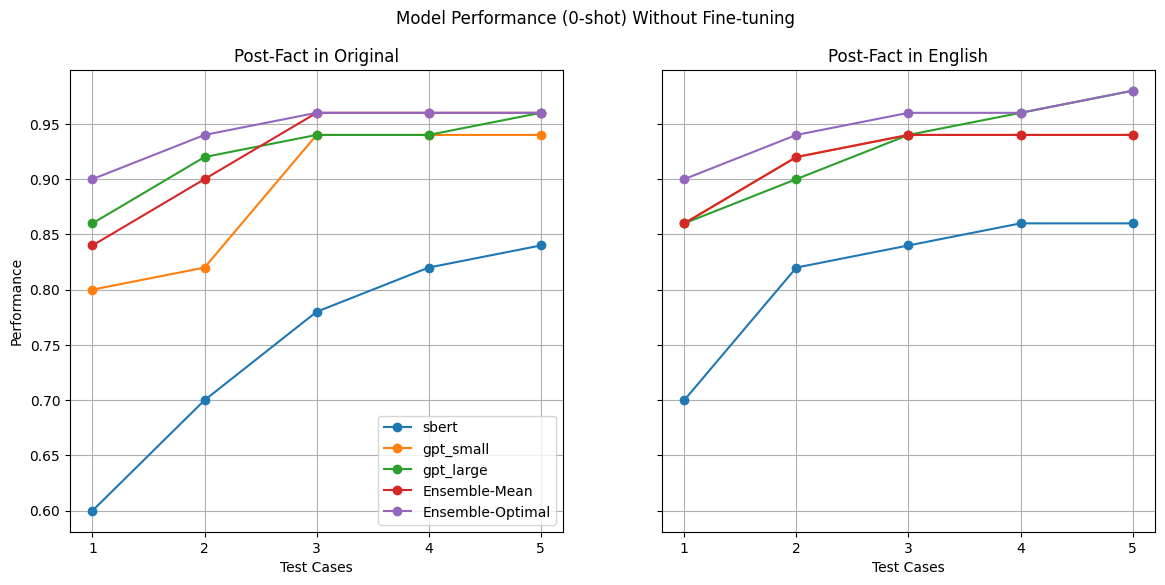

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
models = ['sbert', 'gpt_small', 'gpt_large', 'Ensemble-Mean', 'Ensemble-Optimal']
x_labels = ['1', '2', '3', '4', '5']

post_fact_original_data = [
    [0.60, 0.70, 0.78, 0.82, 0.84],
    [0.80, 0.82, 0.94, 0.94, 0.94],
    [0.86, 0.92, 0.94, 0.94, 0.96],
    [0.84, 0.90, 0.96, 0.96, 0.96],
    [0.90, 0.94, 0.96, 0.96, 0.96]
]

post_fact_english_data = [
    [0.70, 0.82, 0.84, 0.86, 0.86],
    [0.86, 0.92, 0.94, 0.94, 0.94],
    [0.86, 0.90, 0.94, 0.96, 0.98],
    [0.86, 0.92, 0.94, 0.94, 0.94],
    [0.90, 0.94, 0.96, 0.96, 0.98]
]

# Model scores
post_fact_original = np.array(post_fact_original_data)

post_fact_english = np.array(post_fact_english_data)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for Post-Fact in Original
for i, model in enumerate(models):
    ax[0].plot(x_labels, post_fact_original[i], marker='o', label=model)
ax[0].set_title('Post-Fact in Original')
ax[0].set_xlabel('Test Cases')
ax[0].set_ylabel('Accuracy@K')
ax[0].legend(loc='lower right')
ax[0].grid(True)

# Plot for Post-Fact in English
for i, model in enumerate(models):
    ax[1].plot(x_labels, post_fact_english[i], marker='o', label=model)
ax[1].set_title('Post-Fact in English')
ax[1].set_xlabel('K (retrieved facts)')
ax[1].grid(True)

plt.suptitle('Model Performance (0-shot) Without Fine-tuning')
plt.show()

In [4]:
client = OpenAI(api_key = os.getenv('OPENAI_API_KEY'))

In [5]:
eval_facts, eval_posts, eval_mapping = get_data(fact_path="./../sample_data/trial_fact_checks.csv",
                                                posts_path="./../sample_data/trial_posts.csv",
                                                post2fact_mapping_path="./../sample_data/trial_data_mapping.csv")
eval_facts = process_facts_df(eval_facts)
eval_posts = process_posts_df(eval_posts)

In [45]:
tr_facts, tr_posts, tr_mapping = get_data(fact_path="./../in_data/fact_checks.csv",
                                            posts_path="./../in_data/posts.csv",
                                            post2fact_mapping_path="./../in_data/fact_check_post_mapping.csv")
tr_facts = process_facts_df(tr_facts)
tr_posts = process_posts_df(tr_posts)

In [196]:
ix = 39
eval_mapping.iloc[ix]
print(eval_facts.loc[eval_facts.fact_check_id == eval_mapping.iloc[ix].fact_check_id].fact_claim.item()[1])

Video shows Ukrainian pilot escaping Russian attack


In [194]:
print(eval_posts.loc[eval_posts.post_id == eval_mapping.iloc[ix].post_id].post_text.item()[0].replace('\n', " "))

Un piloto ucraniano denominado el fantasma de Kiev  combatiendo y esquivando el ataque ruso  el héroe que derivo 6 aviones ruso   amén para ese valiente piloto 🙏🙏🙏🙏🙏


In [185]:
eval_posts.loc[eval_posts.post_id == eval_mapping.iloc[ix].post_id]

,post_instances,post_ocr,post_verdicts,post_text,post_id,post_l1,post_l2,l1,l2
13,"[(1634131174.0, fb)]",[(전라도에서만 국가유공자가\n50만이라니.이게\n말이되나?김대중.노무현 정권하에서...,[False information],(전라도에서만 국가유공자가\n50만이라니.이게\n말이되나?김대중.노무현 정권하에서\...,13,전라도에서만 국가유공자가\n50만이라니.이게\n말이되나?김대중.노무현 정권하에서\n...,"Only in Jeolla Province, people of national me...",kor,kor


### Get sbert embeddings for the posts & facts

In [4]:
model = SentenceTransformer('sentence-transformers/use-cmlm-multilingual')
model.to('cuda:0')

Some weights of the model checkpoint at sentence-transformers/use-cmlm-multilingual were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [5]:
eval_fact_orig_sbert_emb = get_sbert_embeddings(txt_list = eval_facts.facts_orig.tolist(), model=model, batch_size=128)
eval_fact_eng_sbert_emb = get_sbert_embeddings(txt_list = eval_facts.facts_eng.tolist(), model=model, batch_size=128)

eval_post_l1_sbert_emb = get_sbert_embeddings(txt_list = eval_posts.post_l1.tolist(), model=model, batch_size=128)
eval_post_l2_sbert_emb = get_sbert_embeddings(txt_list = eval_posts.post_l2.tolist(), model=model, batch_size=128)

eval_facts['fact_orig_sbert'] = eval_fact_orig_sbert_emb
eval_facts['fact_eng_sbert'] = eval_fact_eng_sbert_emb

eval_posts['post_l1_sbert'] = eval_post_l1_sbert_emb
eval_posts['post_l2_sbert'] = eval_post_l2_sbert_emb

100%|██████████| 47/47 [00:00<00:00, 209.30it/s]


In [6]:
mdl = 'text-embedding-3-large'
comb_txt_list = eval_facts.apply(lambda x: f"{x['facts_orig'].strip()} <sep> {x['facts_eng'].strip()}", axis = 1).tolist()
eval_fact_orig_sbert_emb = get_openai_embedding(text_list = eval_facts.facts_orig.tolist(), model=mdl, client=client)
eval_fact_eng_sbert_emb = get_openai_embedding(text_list = eval_facts.facts_eng.tolist(), model=mdl, client=client)

comb_txt_list = eval_posts.apply(lambda x: f"{x['post_l1'].strip()} <sep> {x['post_l2'].strip()}", axis = 1).tolist()
eval_post_l1_sbert_emb = get_openai_embedding(text_list = eval_posts.post_l1.tolist(), model=mdl, client=client)
eval_post_l2_sbert_emb = get_openai_embedding(text_list = eval_posts.post_l2.tolist(), model=mdl, client=client)

eval_facts['fact_orig_gpt_large'] = eval_fact_orig_sbert_emb
eval_facts['fact_eng_gpt_large'] = eval_fact_eng_sbert_emb

eval_posts['post_l1_gpt_large'] = eval_post_l1_sbert_emb
eval_posts['post_l2_gpt_large'] = eval_post_l2_sbert_emb

100%|██████████| 47/47 [00:12<00:00,  3.76it/s]


In [7]:
mdl = 'text-embedding-3-small'
comb_txt_list = eval_facts.apply(lambda x: f"{x['facts_orig'].strip()} <sep> {x['facts_eng'].strip()}", axis = 1).tolist()
eval_fact_orig_sbert_emb = get_openai_embedding(text_list = eval_facts.facts_orig.tolist(), model=mdl, client=client)
eval_fact_eng_sbert_emb = get_openai_embedding(text_list = eval_facts.facts_eng.tolist(), model=mdl, client=client)

comb_txt_list = eval_posts.apply(lambda x: f"{x['post_l1'].strip()} <sep> {x['post_l2'].strip()}", axis = 1).tolist()
eval_post_l1_sbert_emb = get_openai_embedding(text_list = eval_posts.post_l1.tolist(), model=mdl, client=client)
eval_post_l2_sbert_emb = get_openai_embedding(text_list = eval_posts.post_l2.tolist(), model=mdl, client=client)

eval_facts['fact_orig_gpt_small'] = eval_fact_orig_sbert_emb
eval_facts['fact_eng_gpt_small'] = eval_fact_eng_sbert_emb

eval_posts['post_l1_gpt_small'] = eval_post_l1_sbert_emb
eval_posts['post_l2_gpt_small'] = eval_post_l2_sbert_emb

100%|██████████| 47/47 [00:09<00:00,  5.13it/s]


In [8]:
from sklearn.metrics.pairwise import cosine_similarity
eval_posts = eval_posts.merge(eval_mapping, on='post_id', how="left")

In [9]:
for mdl in ['gpt_small', 'gpt_large', 'sbert']:
    for post_lang in ['l1', 'l2']:
        for fact_lang in ['orig', 'eng']:
            temp = cosine_similarity(eval_posts[f'post_{post_lang}_{mdl}'].tolist(), eval_facts[f'fact_{fact_lang}_{mdl}'].tolist())
            eval_posts[f'{mdl}_p_{post_lang}_f_{fact_lang}'] = temp.tolist()

Index(['post_instances', 'post_ocr', 'post_verdicts', 'post_text', 'post_id',
       'post_l1', 'post_l2', 'l1', 'l2', 'post_l1_sbert', 'post_l2_sbert',
       'post_l1_gpt_large', 'post_l2_gpt_large', 'post_l1_gpt_small',
       'post_l2_gpt_small', 'fact_check_id', 'pair_lang',
       'gpt_small_p_l1_f_orig', 'gpt_small_p_l1_f_eng',
       'gpt_small_p_l2_f_orig', 'gpt_small_p_l2_f_eng',
       'gpt_large_p_l1_f_orig', 'gpt_large_p_l1_f_eng',
       'gpt_large_p_l2_f_orig', 'gpt_large_p_l2_f_eng', 'sbert_p_l1_f_orig',
       'sbert_p_l1_f_eng', 'sbert_p_l2_f_orig', 'sbert_p_l2_f_eng'],
      dtype='object')

In [11]:
cols = eval_posts.columns.tolist()

# Taking the mean of cosine similarity for each model
for mdl in ['p_l1_f_orig', 'p_l2_f_eng']:
    eval_posts[f'mean_{mdl}'] = eval_posts.apply(lambda x: np.concatenate([np.array(x[c]).reshape(1, -1) for c in cols if c.endswith(mdl)]).mean(axis = 0), axis = 1)

In [12]:
fact_ix2id_mapping = {ix: row['fact_check_id'] for ix, row in eval_facts.iterrows()}
get_post_id = lambda x: fact_ix2id_mapping[x]
vfunc = np.vectorize(get_post_id)

In [56]:
final_result = {}
cols = ['gpt_small_p_l1_f_orig','gpt_small_p_l2_f_eng',
        'gpt_large_p_l1_f_orig', 'gpt_large_p_l2_f_eng',
        'sbert_p_l1_f_orig', 'sbert_p_l2_f_eng',
        'mean_p_l1_f_orig', 'mean_p_l2_f_eng']    
for col in cols:
    res = []
    for k in [1, 2, 3, 4 ,5]:
        res.append(eval_posts.apply(lambda x: x['fact_check_id'] in vfunc(np.argsort(x[col])[::-1][:k]), axis = 1).mean())
    final_result[col] = res

In [57]:
settings = ['p_l1_f_orig','p_l2_f_eng'] 

for setting in settings:
    columns = [c for c in eval_posts.columns.tolist() if c.endswith(setting) and not c.startswith('mean')]
    res = []
    for k in [1, 2, 3, 4 ,5]:
        res.append(eval_posts.apply(lambda x: x['fact_check_id'] in  np.concatenate([vfunc(np.argsort(x[col])[::-1][:k]) for col in columns]), axis = 1).mean())
    final_result[f'optimal_{setting}'] = res

In [58]:
pd.DataFrame({k.split('_p')[0]: v for k, v in final_result.items() if k.endswith('p_l1_f_orig')}).transpose()

,0,1,2,3,4
gpt_small,0.80,0.82,0.94,0.94,0.94
gpt_large,0.86,0.92,0.94,0.94,0.96
sbert,0.60,0.70,0.78,0.82,0.84
mean,0.84,0.90,0.96,0.96,0.96
optimal,0.90,0.94,0.96,0.96,0.96


In [59]:
pd.DataFrame({k.split('_p')[0]: v for k, v in final_result.items() if k.endswith('p_l2_f_eng')}).transpose()

,0,1,2,3,4
gpt_small,0.86,0.92,0.94,0.94,0.94
gpt_large,0.86,0.90,0.94,0.96,0.98
sbert,0.70,0.82,0.84,0.86,0.86
mean,0.86,0.92,0.94,0.94,0.94
optimal,0.90,0.94,0.96,0.96,0.98
